In [ ]:
# detect kangaroos in photos with mask rcnn model
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from bboxcnn.config import Config
from bboxcnn.model import BBoxCNN
from bboxcnn.model import mold_image
from bboxcnn.utils import Dataset

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "Active_IC")
        self.add_class("dataset", 2, "capacitor")
        self.add_class("dataset", 3, "connector")
        self.add_class("dataset", 4, "crystal")
        self.add_class("dataset", 5, "diode")
        self.add_class("dataset", 6, "gnd")
        self.add_class("dataset", 7, "inductor")
        self.add_class("dataset", 8, "led")
        self.add_class("dataset", 9, "misc")
        self.add_class("dataset", 10, "nmos")
        self.add_class("dataset", 11, "npn")
        self.add_class("dataset", 12, "pmos")
        self.add_class("dataset", 13, "pnp")
        self.add_class("dataset", 14, "pwr")
        self.add_class("dataset", 15, "pwr_connector")
        self.add_class("dataset", 16, "resistor")
        self.add_class("dataset", 17, "switch")
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 0:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 0:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # load all bounding boxes for an image
    def extract_boxes(self, filename):
        # load and parse the file
        root = ElementTree.parse(filename)
        boxes = list()
        # extract each bounding box
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    # define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "ec_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 18
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
# load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(1, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()
# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset('/visual_nlp/data/final/test', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset('/visual_nlp/data/new_data/eval', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = BBoxCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'ec_cfg20240616T1903/bboxcnn_ec_cfg_0002.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
# plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

In [ ]:
!cp /visual_nlp/data/new_data/Annotated_Schematic_files_7th_april_2023/KITFS4508CAEEVM-SCH2.png /visual_nlp/data/new_data/eval/images/1.png

In [ ]:
!mkdir /visual_nlp/data/new_data/eval/annots 

In [1]:
# display image with masks and bounding boxes
from os import listdir
import json
from skimage import io
# import cv2
# fit a bounding box cnn on the EID dataset
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from bboxcnn.config import Config
from bboxcnn.model import BBoxCNN
from bboxcnn.model import mold_image
from bboxcnn.utils import Dataset



class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "ec_cfg"
    # number of classes (background + EID Field classes(10))
    NUM_CLASSES = 1 + 18
    # simplify GPU config(Here the GPU and CPU Config are same: It works if Dex sys doesnt have GPU)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
# create config
cfg = PredictionConfig()
# define the model
model = BBoxCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'ec_cfg20240617T1616/bboxcnn_ec_cfg_0020.h5'
model.load_weights(model_path, by_name=True)


class_ids_to_class_name = {1: 'inductor', 2: 'capacitor',  18: 'gnd'}

def load_image(path_to_image):
    source_image = io.imread(path_to_image)
#     source_image = cv2.imread(path, cv2.IMREAD_COLOR)
    scaled_image = mold_image(source_image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    return source_image, sample

def pred(image_path):
    # piece images using bboxes
    dict_ = {}
    class_ids_to_class_name = {1: 'inductor', 2: 'capacitor', 18: 'gnd'}
    source_image, scaled_samp_image = load_image(image_path)
    yhat = model.detect(scaled_samp_image, verbose=0)[0]
    bboxes, class_ids, mask = yhat['rois'], yhat['class_ids'], yhat['masks']
    for bbox, class_id in zip(bboxes, class_ids):
        xmin, ymin, xmax, ymax = bbox
        piece_image = source_image[xmin:xmax, ymin:ymax]
        classname = class_ids_to_class_name[class_id]
        display(piece_image)
    return source_image, bboxes, class_ids

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [2]:
import matplotlib.pyplot as plt
from skimage import io
import matplotlib.patches as patches

def display_image_with_bboxes(image, bboxes, class_ids, bbox_color='red', bbox_width=2):
    """
    Display an image with overlaid bounding boxes and class IDs.

    Parameters:
    - image_path: str, path to the image file.
    - bboxes: list of tuples, where each tuple is (xmin, ymin, xmax, ymax).
    - class_ids: list of class IDs corresponding to each bounding box.
    - bbox_color: str, color of the bounding boxes (default is 'red').
    - bbox_width: int, width of the bounding box line (default is 2).
    """
    # Read the image
#     image = io.imread(image_path)
    
    # Create a figure and axes
    fig, ax = plt.subplots(1, figsize=(28, 22))
    
    # Display the image
    ax.imshow(image)
    
    # Iterate over the bounding boxes and class IDs
    for bbox, class_id in zip(bboxes, class_ids):
#         xmin, ymin, xmax, ymax = bbox
        ymin, xmin, ymax, xmax = bbox
        width = xmax - xmin
        height = ymax - ymin
        
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=bbox_width, edgecolor=bbox_color, facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add class ID text
        plt.text(xmin, ymin - 10, str(class_id), color=bbox_color, fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.5))
#     io.imsave("pred_BB_en.MB1373-L562QEQ-C01_Schematic15.png.png", image)
    # Show the plot
    
    plt.show()

In [5]:
%%time
source_image, bboxes, class_ids = pred('/visual_nlp//data/final/train/images/0002.png')

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [ 38,  38, 146],
        [ 38,  38, 146],
        [ 38,  38, 146]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [ 54,  53, 153],
        [ 54,  53, 153],
        [ 54,  53, 153]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

capacitor


array([[[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       ...,

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]],

       [[255, 251, 247],
        [255, 251, 247],
        [255, 251, 247],
        ...,
        [255, 251, 247],
        [255, 251, 247],
        [255, 251, 247]]

CPU times: user 1min 36s, sys: 2.37 s, total: 1min 38s
Wall time: 17.9 s


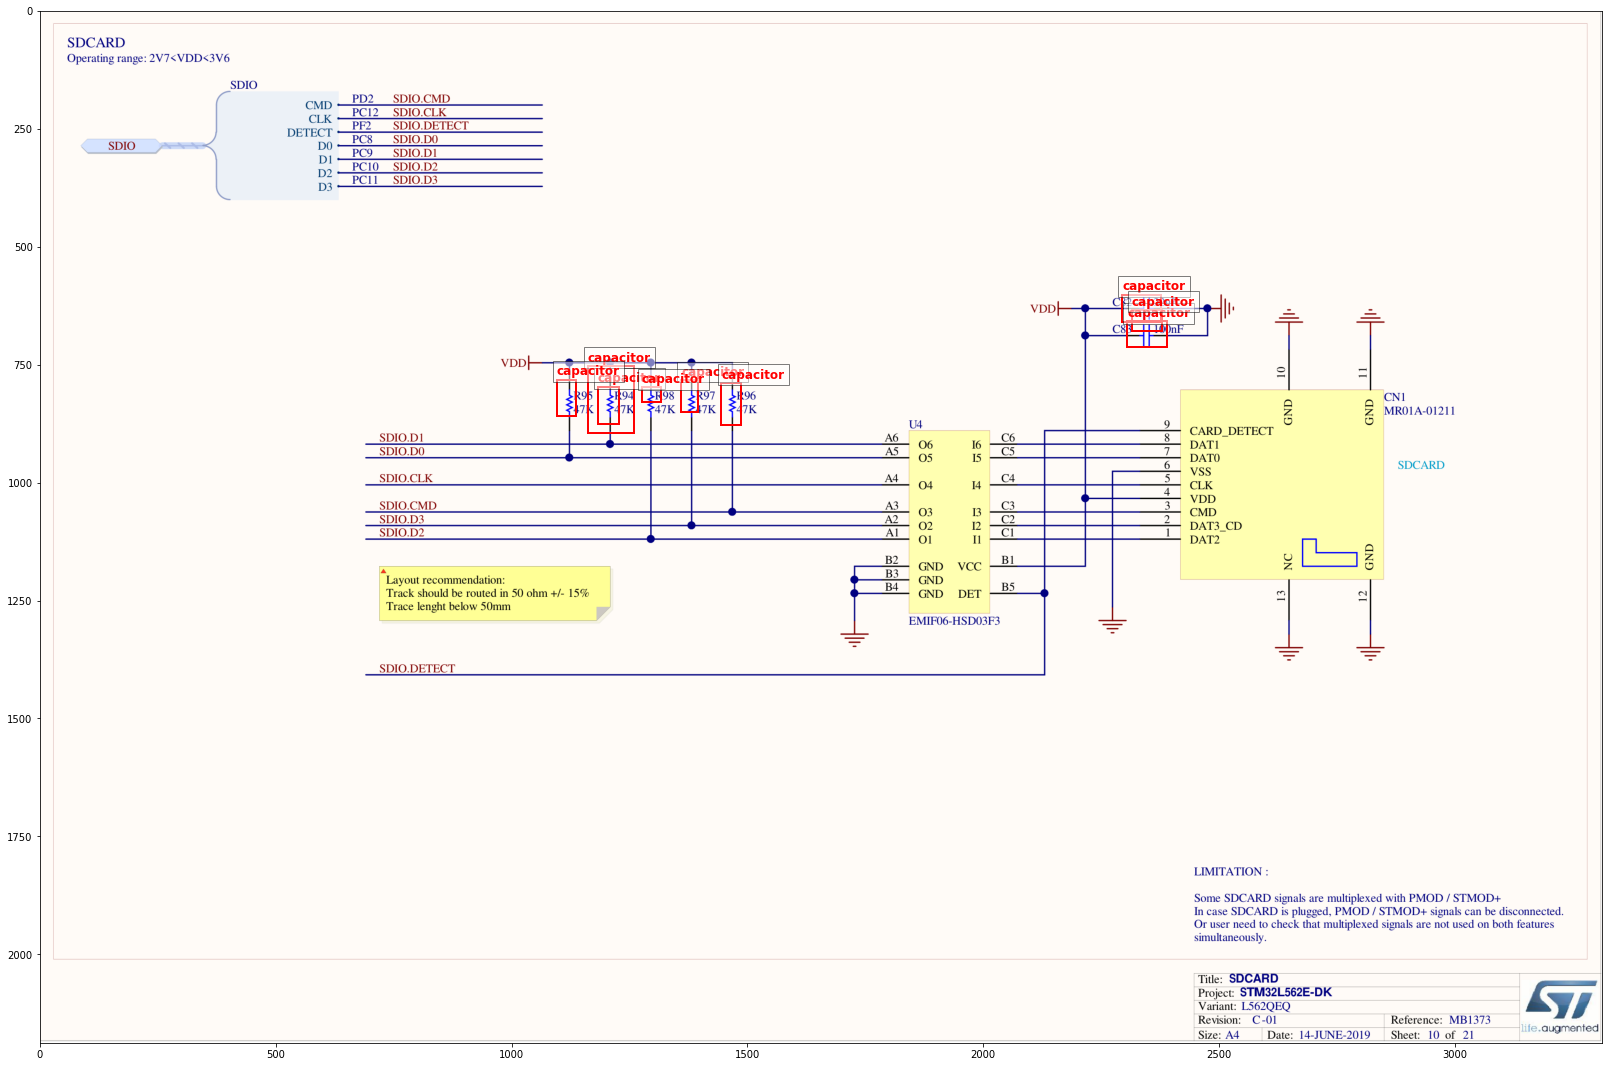

In [6]:
import numpy as np
classname = np.array([class_ids_to_class_name[i] for i in class_ids])
display_image_with_bboxes(source_image, bboxes, classname)

In [ ]:
import numpy as np
classname = np.array([class_ids_to_class_name[i] for i in class_ids])
display_image_with_bboxes(source_image, bboxes, classname)

In [20]:
!pip install opencv-python

  Using cached opencv-python-4.10.0.82.tar.gz (95.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
anceled
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


array([[2316, 3391, 2469, 3463],
       [1527, 1450, 1806, 1574],
       [2730, 3742, 2826, 3794]], dtype=int32)

In [30]:
class_ids_to_class_name

{1: 'inductor',
 2: 'capacitor',
 3: 'resistor',
 4: 'Active_IC',
 5: 'fuse',
 6: 'pnp',
 7: 'npn',
 8: 'crystal',
 9: 'pwr_connector',
 10: 'diode',
 11: 'connectors',
 12: 'switch',
 13: 'headers',
 14: 'pmos',
 15: 'nmos',
 16: 'led',
 17: 'pwr',
 18: 'gnd'}

In [28]:
from glob import glob
annots = glob('/visual_nlp//data/final/test/annots/*')

In [29]:
obj = []
for annot_path in annots:
    with open(annot_path) as json_data:
        d = json.load(json_data)
    labels = []
    boxes = []
    objects = [i['name'] for i in d['object']]
    obj.append(objects)
print(sum(obj, []))

['Active_IC', 'Active_IC', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'Active_IC', 'Active_IC', 'diode', 'diode', 'switch', 'switch', 'switch', 'led', 'led', 'crystal', 'crystal', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'inductor', 'inductor', 'inductor', 'inductor', 'Active_IC', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'Active_IC', 'resistor', 'capacitor', 'capacitor', 'capacitor', '

In [30]:
tes = sum(obj, [])

In [27]:
trai = sum(obj, [])

In [26]:
trai-tes

{'npn'}

In [38]:
def get_frequency(input_list):
    """
    This function returns a dictionary with the frequency of each element in the input list.

    :param input_list: List of elements (can be of any type)
    :return: Dictionary with elements as keys and their frequencies as values
    """
    frequency_dict = {}
    
    for item in input_list:
        if item in frequency_dict:
            frequency_dict[item] += 1
        else:
            frequency_dict[item] = 1
    
    return dict(sorted(frequency_dict.items()))

In [39]:
test_dict = get_frequency(tes)

In [40]:
test_dict

{'Active_IC': 53,
 'capacitor': 433,
 'connectors': 4,
 'crystal': 2,
 'diode': 39,
 'fuse': 1,
 'gnd': 302,
 'headers': 16,
 'inductor': 36,
 'led': 5,
 'nmos': 3,
 'pmos': 2,
 'pnp': 2,
 'pwr': 190,
 'pwr_connector': 1,
 'resistor': 545,
 'switch': 14}

In [42]:
train_dict

{'Active_IC': 436,
 'capacitor': 2523,
 'connectors': 237,
 'crystal': 29,
 'diode': 238,
 'fuse': 2,
 'gnd': 1465,
 'headers': 340,
 'inductor': 161,
 'led': 119,
 'nmos': 51,
 'npn': 11,
 'pmos': 9,
 'pnp': 5,
 'pwr': 878,
 'pwr_connector': 4,
 'resistor': 2985,
 'switch': 62}

In [41]:
train_dict = get_frequency(trai)